In [1]:
import numpy as np
import matplotlib.pyplot as plt
import reportParser
import pandas as pd
from isotherm import Isotherm

In [2]:
data = Isotherm()
data.load_kernel()

In [3]:
raw_data = reportParser.get_isotherm_and_distribution("test_report.txt")
isotherm_data = reportParser.get_numpy_arrays(raw_data)

#
norit = pd.read_csv("carbon task/norit.txt", delimiter=" ")
#
data.isothermData = norit["a"]#isotherm_data["adsorption"]
data.pressureData = norit["p"] / max(norit["p"])#isotherm_data["p_adsorption"]
data.interpolate_isotherm()
data.process_kernel()

C:\Users\ivano\PycharmProjects\isotherm\tools\reportParser.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(io.StringIO(value), sep="\s+|\t+|\s+\t+|\t+\s+")
C:\Users\ivano\PycharmProjects\isotherm\tools\reportParser.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(io.StringIO(value), sep="\s+|\t+|\s+\t+|\t+\s+")


In [4]:
alpha = 1
beta = 0

In [5]:
data.process_isotherm(alpha, beta)

C:\Users\ivano\PycharmProjects\isotherm\inverse.py:17: RuntimeWarning: divide by zero encountered in log
  adsorption)).sum(axis=0) + alpha * np.sum(pore_dist * np.log(pore_dist)) +
C:\Users\ivano\PycharmProjects\isotherm\inverse.py:17: RuntimeWarning: invalid value encountered in multiply
  adsorption)).sum(axis=0) + alpha * np.sum(pore_dist * np.log(pore_dist)) +


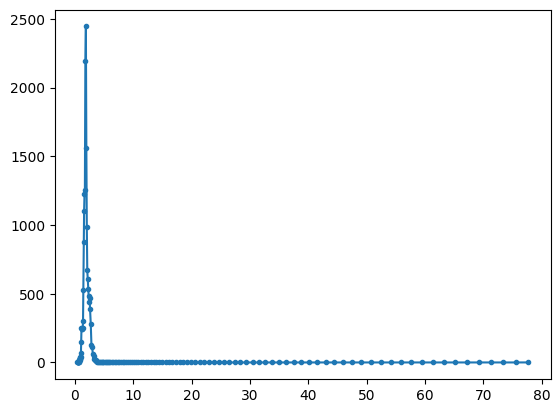

In [6]:
plt.plot(data.kernel_a_array, data.defined_PSD, marker=".")
plt.show()

In [7]:
def calculate_isotherm_error(data):
    return np.square(np.subtract(data.restored_isotherm, data.interpolated_isotherm)).sum(axis=0)

def calculate_alpha_regularisation_error(data):
    return np.sum(data.defined_PSD * np.log(data.defined_PSD))

def calculate_beta_regularisation_error(data):
    return np.sum(np.square(np.diff(data.defined_PSD)/data.kernel_a_array[:-1]))

In [8]:
calculate_isotherm_error(data)

11449.409246906596

In [9]:
calculate_alpha_regularisation_error(data)

125175.35430921921

In [14]:
beta_array = [0,0.001, 0.005, 0.01, 0.05, 0.1,  0.5, 1]
isotherm_errors = []
regularisation_errors = []
for beta in beta_array:
    data.process_isotherm(0, beta)
    isotherm_errors.append(calculate_isotherm_error(data))
    #regularisation_errors.append(calculate_alpha_regularisation_error(data))
    regularisation_errors.append(calculate_beta_regularisation_error(data))

C:\Users\ivano\PycharmProjects\isotherm\inverse.py:17: RuntimeWarning: divide by zero encountered in log
  adsorption)).sum(axis=0) + alpha * np.sum(pore_dist * np.log(pore_dist)) +
C:\Users\ivano\PycharmProjects\isotherm\inverse.py:17: RuntimeWarning: invalid value encountered in multiply
  adsorption)).sum(axis=0) + alpha * np.sum(pore_dist * np.log(pore_dist)) +


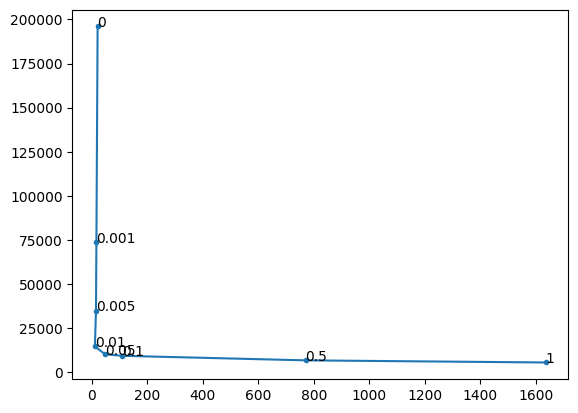

In [15]:
plt.plot(isotherm_errors, regularisation_errors, marker=".")
for i, txt in enumerate(beta_array):
    plt.annotate(txt, (isotherm_errors[i], regularisation_errors[i]))